In [ ]:
# Input data files are available in the "../input/" directory.
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv("C://Users//ESTHER//Documents//complaints.csv")
df.shape

(4065103, 18)

In [32]:
df.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-09-04,"Money transfer, virtual currency, or money ser...",Mobile or digital wallet,Trouble accessing funds in your mobile or digi...,NaN,NaN,NaN,"Paypal Holdings, Inc",NC,27587,NaN,NaN,Web,2023-09-04,Closed with explanation,Yes,NaN,7493283
1,2023-09-06,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,NaN,Company believes the complaint is the result o...,"CCS Financial Services, Inc.",FL,33032,NaN,NaN,Web,2023-09-06,Closed with explanation,Yes,NaN,7510657


In [ ]:
df.head(2).T # Columns are shown in rows for easy reading

In [4]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(1472203, 2)

In [5]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

In [6]:
pd.DataFrame(df.Product.unique()).values

array([['Money transfer, virtual currency, or money service'],
       ['Debt collection'],
       ['Checking or savings account'],
       ['Credit reporting or other personal consumer reports'],
       ['Mortgage'],
       ['Credit card'],
       ['Vehicle loan or lease'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Student loan'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Credit card or prepaid card'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Bank account or service'],
       ['Payday loan, title loan, or personal loan'],
       ['Debt or credit management'],
       ['Credit reporting'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

In [7]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [8]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Mortgage
2,Checking or savings account
3,Credit card or prepaid card
4,Debt collection
5,"Money transfer, virtual currency, or money ser..."
6,"Payday loan, title loan, or personal loan"
7,Student loan
8,Consumer Loan
9,Vehicle loan or lease


In [9]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
337270,"Credit reporting, repair, or other",The date of my first letter was XXXX. I sent a...,0
814826,"Credit reporting, repair, or other",I was XXXX and my ID and social security card ...,0
1157572,"Credit reporting, repair, or other",I'm really not sure what happened. I have mail...,0
589205,Mortgage,I was impacted by hurricane Irma and then Mich...,1
2863449,Checking or savings account,I am a XXXX XXXX XXXX by trade. \n\nAt the en...,2


In [ ]:
#DATA VISUALIZATION

<Axes: ylabel='Product'>

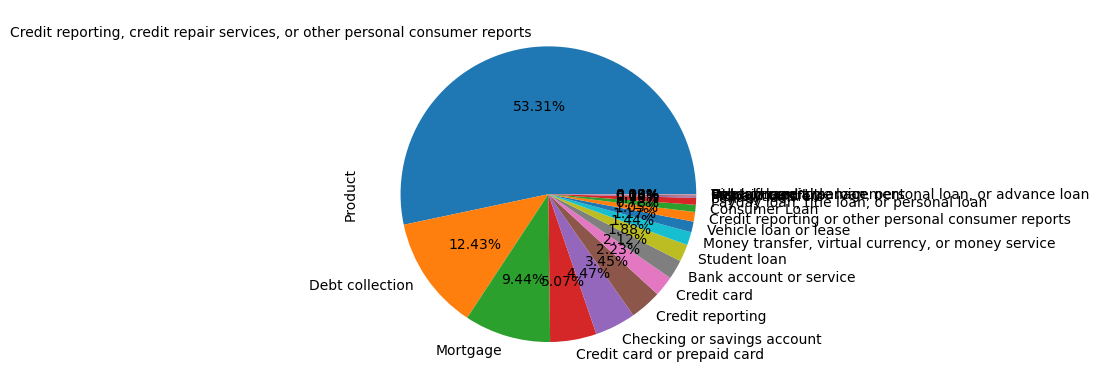

In [43]:
df["Product"].value_counts().plot(kind="pie", autopct="%.2f%%")

In [ ]:
df["Sub-product"].value_counts().head(10).plot(kind="pie", autopct="%.2f%%")

In [ ]:
df["Issue"].value_counts().head(10).plot(kind="pie", autopct="%.2f%%")

In [ ]:
df["Sub-issue"].value_counts().head(10).plot(kind="pie", autopct="%.2f%%")

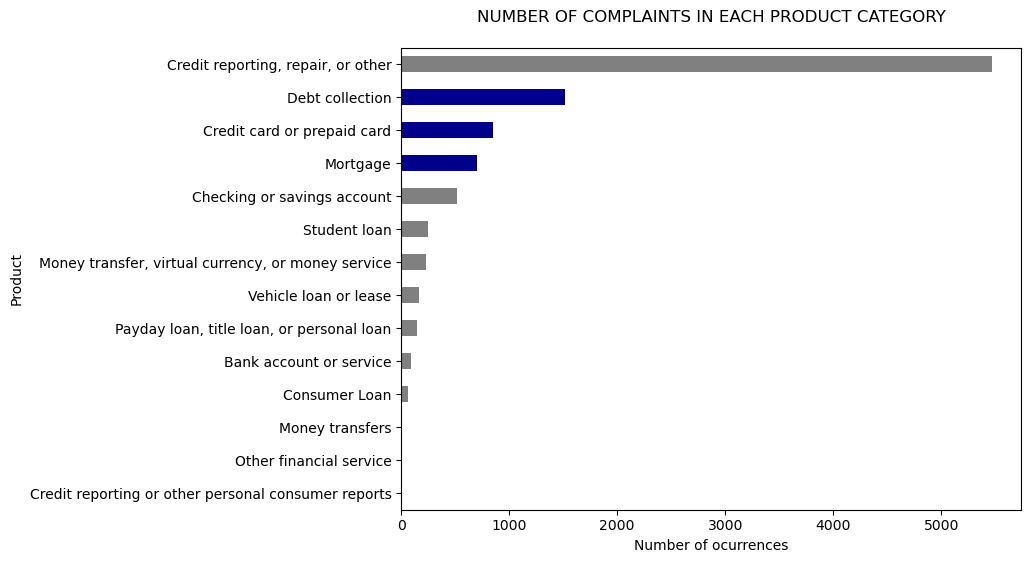

In [36]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [34]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26339 features (TF-IDF score of unigrams and bigrams)


In [37]:
#Multi-Classification models
#The classification models evaluated are:
#Random Forest
#Linear Support Vector Machine
#Multinomial Naive Bayes
#Logistic Regression.

In [17]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [ ]:
#Model 

In [18]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\ESTHER\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ESTHER\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\ESTHER\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\ESTHER\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\ESTHER\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True`

In [ ]:
#Comparison of model performance

In [ ]:
cv_df.head()

In [19]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc


,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8236,0.006941
LogisticRegression,0.8054,0.008242
MultinomialNB,0.6794,0.007154
RandomForestClassifier,0.5465,0.000000


In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [ ]:
#Model Evaluation

In [20]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\ESTHER\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [39]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')


				CLASSIFICATIION METRICS



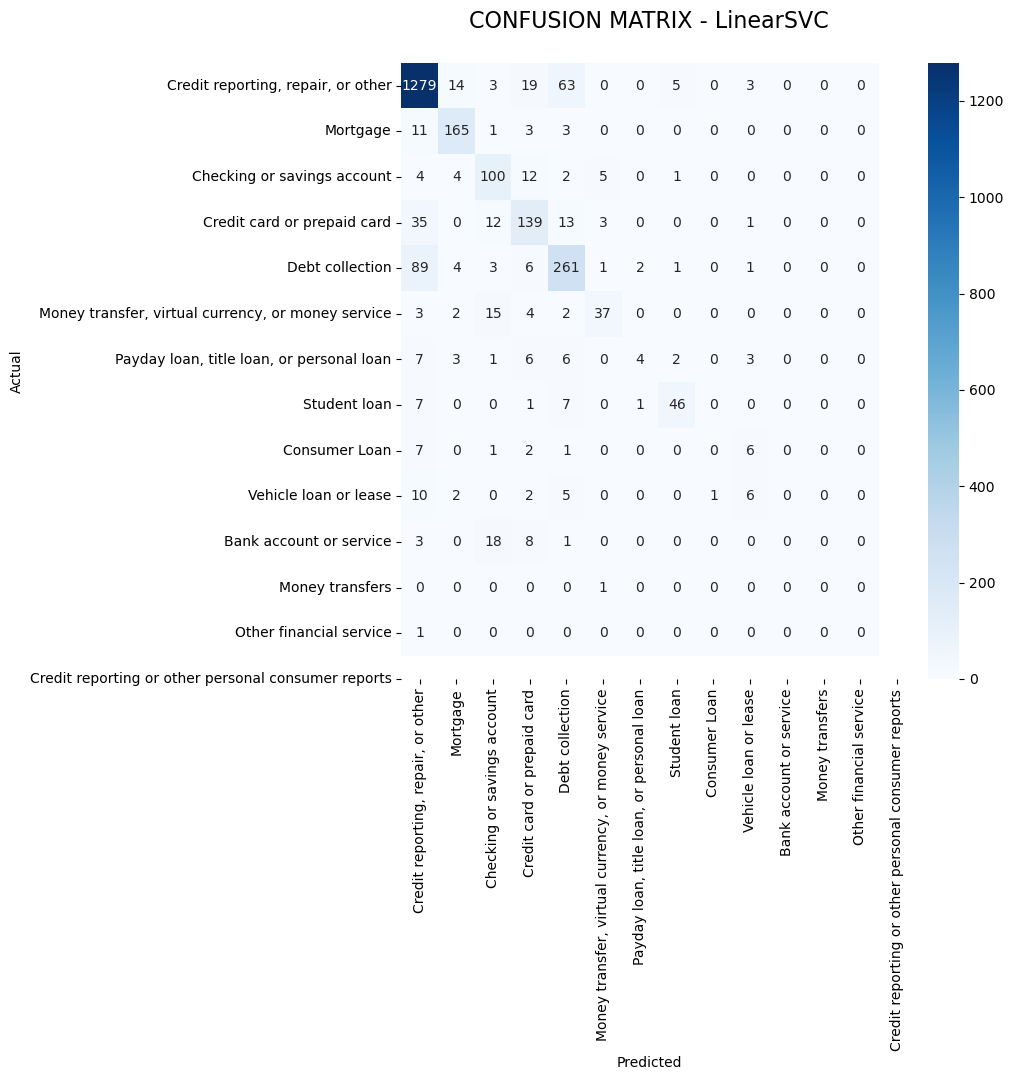

In [23]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [24]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
            print('')

'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 35 examples.


,Product,Consumer_complaint
1795848,Credit card or prepaid card,I have had several credit cards closed by issu...
471714,Credit card or prepaid card,I am XXXX XXXX XXXX and I am submitting this c...
1439608,Credit card or prepaid card,CHASE CARD MADE A HARD INQUIRE ON MY CREDIT RE...
2380553,Credit card or prepaid card,I checked my report on XX/XX/2021 and see this...
986201,Credit card or prepaid card,I have not received confirmation not certified...
1866351,Credit card or prepaid card,There are duplicate accounts reflected on all ...
811589,Credit card or prepaid card,"On XX/XX/XXXX, I called XXXX XXXX XXXX to inqu..."
532930,Credit card or prepaid card,XXXX card did a hard inquiry in my credit with...
1869638,Credit card or prepaid card,The following debit card transactions of withd...
3241057,Credit card or prepaid card,It is highly unjustifiable to have late paymen...



'Debt collection' predicted as 'Credit reporting, repair, or other' : 89 examples.


,Product,Consumer_complaint
1332531,Debt collection,I have been disputing this account with Wells ...
3721812,Debt collection,I noticed these accounts reflecting on my cred...
2084414,Debt collection,I have contacted consumer adjustment company i...
1835001,Debt collection,I am the general executor and trustee of the X...
2337054,Debt collection,I have contacted this company through the cred...
...,...,...
804289,Debt collection,On XX/XX/2018 notice XXXX XXXX balance of {$26...
3509657,Debt collection,This dept is not mine and its. Makeing my life...
3313205,Debt collection,im receving bills from Lowes for someone named...
1478356,Debt collection,THIS INFORMATION IS INCORRECT IN MORE THAN ONE...


IndexError: index 13 is out of bounds for axis 0 with size 13

In [40]:
#predictions

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

C:\Users\ESTHER\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [41]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


In [30]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']
